<a href="https://colab.research.google.com/github/lukemckinstry/fastai-projects/blob/master/TweetLanguageModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TweetData

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *
from fastai import *


### Google Colab Authentication

In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()
drive_service = build('drive', 'v3')

In [0]:
def _create_file_request(file_id):
    return drive_service.files().get_media(fileId=file_id)


def _download_response_bytes(request, print_progress=False):
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    
    for status in _progbar(downloader):
        if print_progress:
            print("Downloaded {}/{} bytes".format(status.resumable_progress, status.total_size))
  
    downloaded.seek(0)
    return downloaded.read()

  
def _progbar(downloader):
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        yield status


def get_file_id(name):
    return get_matching_files(name)[0]['id']


def move_from_drive_to_disk(file_names, file_destinations):
    for file_name, dest in zip(file_names, file_destinations):
        file_id = get_file_id(file_name)
        print('Downloading file: "{}"'.format(file_name))
        file_bytes = _download_response_bytes(_create_file_request(file_id), print_progress=True)
        with open(dest, "wb") as f:
            f.write(file_bytes)


def load_pickled_files(file_names):
    for name in file_names:
        yield pickle.load(open(name, "rb"))
        

def get_matching_files(name):
    drive_files_response = _download_response_bytes(drive_service.files().list())
    drive_files_response_dict = json.loads(
        drive_files_response.decode('utf-8')
    )
    drive_files_dict = drive_files_response_dict['files']
  
    matching_records = [
        record
        for record in drive_files_dict
        if record['name'] == name
    ]

    no_records = len(matching_records)
    if no_records == 0:
        raise ValueError('no such file: "{}" on your Google Drive'.format(name))
    elif no_records > 1:
        print('warning: multiple matches for file "{}"'.format(name))
    return matching_records

In [8]:
train_file_name = 'twclean.csv'
train_drive_file_id = get_file_id(train_file_name)

DATA_DIR = Path('/content/data/tweets/')
DATA_DIR.mkdir(exist_ok=True, parents=True)
move_from_drive_to_disk([train_file_name], [DATA_DIR/train_file_name])

Downloaded 5465487/5465487 bytes


In [9]:
!ls {DATA_DIR}

twclean.csv


### Preparing Tweet Data

In [0]:
data_lm = TextLMDataBunch.from_csv(DATA_DIR, 'tw.csv', text_cols = 0)

In [0]:
data_lm.save()
#!ls {DATA_DIR}

In [0]:
data = load_data(DATA_DIR)

In [0]:
data.show_batch()

## Load Learner, Find LR

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [0]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


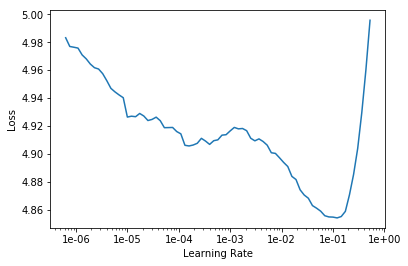

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.232034,4.060273,0.292894


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.958489,3.885153,0.310139
2,3.871605,3.814774,0.319821
3,3.804589,3.767966,0.325793
4,3.771248,3.729666,0.330175
5,3.677534,3.699244,0.333532
6,3.644140,3.674071,0.336564
7,3.603597,3.655099,0.338747
8,3.524271,3.641979,0.340568
9,3.505476,3.636194,0.341246
10,3.461232,3.635963,0.341371


In [0]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because of the cool scenery and the high level of xxmaj british hunting . xxmaj the only thing this movie has going for it is the horrible acting and no script . xxmaj the movie was a big disappointment . xxmaj
I liked this movie because it was one of the few movies that made me laugh so hard i did n't like it . xxmaj it was a hilarious film and it was very entertaining . 

 xxmaj the acting was great , i 'm


We not only have to save the model, but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [0]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [0]:
path = untar_data(URLs.IMDB)

In [0]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [0]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj titanic directed by xxmaj james xxmaj cameron presents a fictional love story on the historical setting of the xxmaj titanic . xxmaj the plot is simple , xxunk , or not for those who love plots that twist and turn and keep you in suspense . xxmaj the end of the movie can be figured out within minutes of the start of the film , but the love",pos
"xxbos xxmaj here are the matches . . . ( adv . = advantage ) \n\n xxmaj the xxmaj warriors ( xxmaj ultimate xxmaj warrior , xxmaj texas xxmaj tornado and xxmaj legion of xxmaj doom ) v xxmaj the xxmaj perfect xxmaj team ( xxmaj mr xxmaj perfect , xxmaj ax , xxmaj smash and xxmaj crush of xxmaj demolition ) : xxmaj ax is the first to go",neg
"xxbos i felt duty bound to watch the 1983 xxmaj timothy xxmaj dalton / xxmaj zelah xxmaj clarke adaptation of "" xxmaj jane xxmaj eyre , "" because i 'd just written an article about the 2006 xxup bbc "" xxmaj jane xxmaj eyre "" for xxunk . \n\n xxmaj so , i approached watching this the way i 'd approach doing homework . \n\n i was irritated at first",pos
"xxbos xxmaj no , this is n't a sequel to the fabulous xxup ova series , but rather a remake of the events that occurred after the death of xxmaj xxunk ( and the disappearance of xxmaj woodchuck ) . xxmaj it is also more accurate to the novels that inspired this wonderful series , which is why characters ( namely xxmaj orson and xxmaj xxunk ) are xxunk ,",pos


We can then create a model to classify those reviews and load the encoder we saved before.

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [0]:
learn.lr_find()

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.310078,0.197204,0.926960


In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.255913,0.169186,0.937800


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.223174,0.165679,0.939600


In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.240424,0.155204,0.943160
2,0.217462,0.153421,0.943960


In [0]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([7.5928e-04, 9.9924e-01]))